# Здесь описать цели работы, гипотезу и идеи

In [311]:
import requests
import json
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plots to png
save_plots_to_file = True
# plots style
sns.set_style()
sns.set_theme()
plt.style.use("dark_background")


# data have many ';' and ','
csv_delimiter = "::"
# indicators to analysis

# pairs ("full str from indicators.csv", "custom shortname")
raw_indicators = [
    ("GDP (current US$)::NY.GDP.MKTP.CD::0", "GDP"),
    ("GDP per capita (constant 2015 US$)::NY.GDP.PCAP.KD::0", "GDP per capita"), # fix 2010 to 2015 (error in csv)
    ("Inflation, consumer prices (annual %)::FP.CPI.TOTL.ZG::0", "inflation"),
    ("Unemployment, total (% of total labor force) (modeled ILO estimate)::SL.UEM.TOTL.ZS::0", "unemployment"),
    ("Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)::SE.TER.CUAT.BA.ZS::0", "educational attainment"),
    ("Government expenditure on education, total (% of government expenditure)::SE.XPD.TOTL.GB.ZS::0", "education expenditure"),
    ("Domestic general government health expenditure (% of general government expenditure)::SH.XPD.GHED.GE.ZS::0", "health expenditure"),
    ("GNI per capita, Atlas method (current US$)::NY.GNP.PCAP.CD::0", "GNI per capita"),
    ("Life expectancy at birth, total (years)::SP.DYN.LE00.IN::0", "life expectancy"),
    ("Birth rate, crude (per 1,000 people)::SP.DYN.CBRT.IN::0", "birth rate"),
    ("Death rate, crude (per 1,000 people)::SP.DYN.CDRT.IN::0", "death rate"),
    ("Suicide mortality rate (per 100,000 population)::SH.STA.SUIC.P5::0", "suicide mortality rate"),
    ("Goods imports (BoP, current US$)::BM.GSR.MRCH.CD::0", "goods imports"),
    ("Service imports (BoP, current US$)::BM.GSR.NFSV.CD::0", "services imports"),
    ("Goods exports (BoP, current US$)::BX.GSR.MRCH.CD::0", "goods exports"),
    ("Service exports (BoP, current US$)::BX.GSR.NFSV.CD::0", "services exports"),
    ("Imports of goods and services (current US$)::NE.IMP.GNFS.CD::0", "total imports"),
    ("Exports of goods and services (current US$)::NE.EXP.GNFS.CD::0", "total exports"),
    ("Population, total::SP.POP.TOTL::0", "population"),
    ("People using at least basic drinking water services (% of population)::SH.H2O.BASW.ZS::0", "basic water services"),
    ("Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)::SH.ALC.PCAP.LI::0", "alcohol consumption"),
    ("School enrollment, primary (% gross)::SE.PRM.ENRR::0", "primary school enrollment"),
    ("School enrollment, secondary (% gross)::SE.SEC.ENRR::0", "secondary school enrollment"),
    ("School enrollment, tertiary (% gross)::SE.TER.ENRR::0", 'tertiary school enrollment'),
    ("PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)::EN.ATM.PM25.MC.ZS::0", "air pollution")
]

indicators = list(map(lambda x: x[0].split(csv_delimiter)[1], raw_indicators))


def download_json(url: str, filepath: str):
    """Download json from url and return result"""
    dataset_request = requests.get(
        url,
        stream=True,
    )
    # write bytes to file
    with open(filepath, "wb") as file:
        for chunk in dataset_request.iter_content(chunk_size=128):
            file.write(chunk)
    # read downloaded json
    with open(filepath, "rt") as file:
        res = json.load(file)
    return res


def download_indicators_list():
    """Get full list of indicators from specified datasets and write to inticators.csv"""
    datasets_ids = [
        "0037712",  # World Development Indicators
        "0037798",  # Global Economical Monitor
    ]
    with open("indicators.csv", "wt") as indicators_file:
        print("name", "id", "load", sep=csv_delimiter, file=indicators_file)
        for dataset_unique_id in datasets_ids:
            # get dataset info
            dataset_url = f"https://datacatalogapi.worldbank.org/ddhxext/DatasetView?dataset_unique_id={dataset_unique_id}"
            dataset_metadata_path = f"datasets_metadata/{dataset_unique_id}.json"
            indicators = download_json(dataset_url, dataset_metadata_path)
            # get data for each indicator
            for indicator in indicators["Indicator"]:
                # parse url to get values
                name = indicator.split("::")[0]
                id = indicator.split("=")[-1]
                load = 0
                print(name, id, load, sep=csv_delimiter, file=indicators_file)


def get_indicators_data(indicators=None):
    """Download indicators from DataBank. If not specified based on settings from indicators.csv)"""
    all_indicators = pd.read_csv(
        "indicators.csv", delimiter=csv_delimiter, engine="python"
    )
    if indicators:
        needed_indicators = indicators
    else:
        needed_indicators = all_indicators[all_indicators["load"] == 1]["id"]
    df = pd.DataFrame(columns=["country", "date"])
    for id in needed_indicators:
        json_path = f"indicators/json/{id}.json"
        csv_path = f"indicators/csv/{id}.csv"
        # skip already loaded indicators
        if os.path.exists(csv_path):
            print(id, "is already loaded")
        else:
            url = f"https://api.worldbank.org/v2/country/all/indicator/{id}?per_page=20000&format=json"
            print("Downloading", id)
            data = download_json(url, json_path)
            # check if got valid data
            if len(data) != 2:
                print(f"Not found {id}")
                continue
            # convert raw json data to csv
            with open(csv_path, "wt") as csv_file:
                name = data[1][0]["indicator"]["value"]
                print("country", "date", name, sep=csv_delimiter, file=csv_file)
                for row in data[1]:
                    country = row["country"]["value"]
                    date = row["date"]
                    value = row["value"]
                    print(country, date, value, sep=csv_delimiter, file=csv_file)

        # read downloaded csv
        new = pd.read_csv(csv_path, delimiter=csv_delimiter, engine="python")
        # drop empty rows
        new.dropna(how="any", inplace=True)
        # merge with main dataset
        df = pd.merge(left=df, right=new, how="outer", on=("country", "date"))

    return df

In [312]:
# download_indicators_list()
raw_df = get_indicators_data(indicators)

NY.GDP.MKTP.CD is already loaded
NY.GDP.PCAP.KD is already loaded
FP.CPI.TOTL.ZG is already loaded
SL.UEM.TOTL.ZS is already loaded
SE.TER.CUAT.BA.ZS is already loaded
SE.XPD.TOTL.GB.ZS is already loaded
SH.XPD.GHED.GE.ZS is already loaded
NY.GNP.PCAP.CD is already loaded
SP.DYN.LE00.IN is already loaded
SP.DYN.CBRT.IN is already loaded
SP.DYN.CDRT.IN is already loaded
SH.STA.SUIC.P5 is already loaded
BM.GSR.MRCH.CD is already loaded
BM.GSR.NFSV.CD is already loaded
BX.GSR.MRCH.CD is already loaded
BX.GSR.NFSV.CD is already loaded
NE.IMP.GNFS.CD is already loaded
NE.EXP.GNFS.CD is already loaded
SP.POP.TOTL is already loaded
SH.H2O.BASW.ZS is already loaded
SH.ALC.PCAP.LI is already loaded
SE.PRM.ENRR is already loaded
SE.SEC.ENRR is already loaded
SE.TER.ENRR is already loaded


In [313]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16930 entries, 0 to 16929
Data columns (total 27 columns):
 #   Column                                                                                                Non-Null Count  Dtype  
---  ------                                                                                                --------------  -----  
 0   country                                                                                               16930 non-null  object 
 1   date                                                                                                  16930 non-null  int64  
 2   GDP (current US$)                                                                                     13979 non-null  float64
 3   GDP per capita (constant 2015 US$)                                                                    13963 non-null  float64
 4   Inflation, consumer prices (annual %)                                                               

# Переименование столбцов

In [314]:
replace_rules = {
    i[0].split(csv_delimiter)[0]: i[1] for i in raw_indicators
}

for a, b in replace_rules.items():
    if a in raw_df.columns:
        raw_df[b] = raw_df[a]
        raw_df.drop(columns=[a], inplace=True)

In [315]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16930 entries, 0 to 16929
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   country                      16930 non-null  object 
 1   date                         16930 non-null  int64  
 2   GDP                          13979 non-null  float64
 3   GDP per capita               13963 non-null  float64
 4   inflation                    11004 non-null  float64
 5   unemployment                 7752 non-null   float64
 6   educational attainment       1332 non-null   float64
 7   education expenditure        4537 non-null   float64
 8   health expenditure           4504 non-null   float64
 9   GNI per capita               12385 non-null  float64
 10  life expectancy              16124 non-null  float64
 11  birth rate                   16300 non-null  float64
 12  death rate                   16282 non-null  float64
 13  suicide mortalit

# Отбор стран для анализа

In [316]:
# regions to take into statistics
# source data includes many regions (not counties)
# this is an array of countries

include_regions = np.array(
    [
        "Afghanistan",
        "Albania",
        "Algeria",
        "American Samoa",
        "Andorra",
        "Angola",
        "Antigua and Barbuda",
        "Argentina",
        "Armenia",
        "Aruba",
        "Australia",
        "Austria",
        "Azerbaijan",
        "Bahamas, The",
        "Bahrain",
        "Bangladesh",
        "Barbados",
        "Belarus",
        "Belgium",
        "Belize",
        "Benin",
        "Bermuda",
        "Bhutan",
        "Bolivia",
        "Bosnia and Herzegovina",
        "Botswana",
        "Brazil",
        "British Virgin Islands",
        "Brunei Darussalam",
        "Bulgaria",
        "Burkina Faso",
        "Burundi",
        "Cabo Verde",
        "Cambodia",
        "Cameroon",
        "Canada",
        "Cayman Islands",
        "Central African Republic",
        "Chad",
        "Channel Islands",
        "Chile",
        "China",
        "Colombia",
        "Comoros",
        "Congo, Dem. Rep.",
        "Congo, Rep.",
        "Costa Rica",
        "Cote d'Ivoire",
        "Croatia",
        "Cuba",
        "Curacao",
        "Cyprus",
        "Czechia",
        "Denmark",
        "Djibouti",
        "Dominica",
        "Dominican Republic",
        "Ecuador",
        "Egypt, Arab Rep.",
        "El Salvador",
        "Equatorial Guinea",
        "Eritrea",
        "Estonia",
        "Eswatini",
        "Ethiopia",
        "Faroe Islands",
        "Fiji",
        "Finland",
        "France",
        "French Polynesia",
        "Gabon",
        "Gambia, The",
        "Georgia",
        "Germany",
        "Ghana",
        "Gibraltar",
        "Greece",
        "Greenland",
        "Grenada",
        "Guam",
        "Guatemala",
        "Guinea",
        "Guinea-Bissau",
        "Guyana",
        "Haiti",
        "Honduras",
        "Hong Kong SAR, China",
        "Hungary",
        "Iceland",
        "India",
        "Indonesia",
        "Iran, Islamic Rep.",
        "Iraq",
        "Ireland",
        "Isle of Man",
        "Israel",
        "Italy",
        "Jamaica",
        "Japan",
        "Jordan",
        "Kazakhstan",
        "Kenya",
        "Kiribati",
        "Korea, Dem. People's Rep.",
        "Korea, Rep.",
        "Kosovo",
        "Kuwait",
        "Kyrgyz Republic",
        "Lao PDR",
        "Latvia",
        "Lebanon",
        "Lesotho",
        "Liberia",
        "Libya",
        "Liechtenstein",
        "Lithuania",
        "Luxembourg",
        "Macao SAR, China",
        "Madagascar",
        "Malawi",
        "Malaysia",
        "Maldives",
        "Mali",
        "Malta",
        "Marshall Islands",
        "Mauritania",
        "Mauritius",
        "Mexico",
        "Micronesia, Fed. Sts.",
        "Moldova",
        "Monaco",
        "Mongolia",
        "Montenegro",
        "Morocco",
        "Mozambique",
        "Myanmar",
        "Namibia",
        "Nauru",
        "Nepal",
        "Netherlands",
        "New Caledonia",
        "New Zealand",
        "Nicaragua",
        "Niger",
        "Nigeria",
        "North Macedonia",
        "Northern Mariana Islands",
        "Norway",
        "Oman",
        "Pakistan",
        "Palau",
        "Panama",
        "Papua New Guinea",
        "Paraguay",
        "Peru",
        "Philippines",
        "Poland",
        "Portugal",
        "Puerto Rico",
        "Qatar",
        "Romania",
        "Russian Federation",
        "Rwanda",
        "Samoa",
        "San Marino",
        "Sao Tome and Principe",
        "Saudi Arabia",
        "Senegal",
        "Serbia",
        "Seychelles",
        "Sierra Leone",
        "Singapore",
        "Sint Maarten (Dutch part)",
        "Slovak Republic",
        "Slovenia",
        "Solomon Islands",
        "Somalia",
        "South Africa",
        "South Sudan",
        "Spain",
        "Sri Lanka",
        "St. Kitts and Nevis",
        "St. Lucia",
        "St. Martin (French part)",
        "St. Vincent and the Grenadines",
        "Sudan",
        "Suriname",
        "Sweden",
        "Switzerland",
        "Syrian Arab Republic",
        "Tajikistan",
        "Tanzania",
        "Thailand",
        "Timor-Leste",
        "Togo",
        "Tonga",
        "Trinidad and Tobago",
        "Tunisia",
        "Turkiye",
        "Turkmenistan",
        "Turks and Caicos Islands",
        "Tuvalu",
        "Uganda",
        "Ukraine",
        "United Arab Emirates",
        "United Kingdom",
        "United States",
        "Uruguay",
        "Uzbekistan",
        "Vanuatu",
        "Venezuela, RB",
        "Viet Nam",
        "Virgin Islands (U.S.)",
        "West Bank and Gaza",
        "Yemen, Rep.",
        "Zambia",
        "Zimbabwe",
    ],
    dtype=object,
)

In [317]:
# dataset of needed countries
cleared_df = raw_df[raw_df["country"].isin(include_regions)]

# countries in each group
N = 7
# years to analyze (including edges)
start_year = 1995
end_year = 2020

# arrange by last available year
top_absolute_GDP_countries = (
    cleared_df[cleared_df["date"] == 2023]
    .sort_values("GDP", ascending=False)[:N]["country"]  # group 1
    .reset_index(drop=True)
)
top_GDP_per_capita_countries = (
    cleared_df[cleared_df["date"] == 2023]
    .sort_values("GDP per capita", ascending=False)[:N]["country"]  # group 2
    .reset_index(drop=True)
)

In [318]:
print(
    f"Top {N} countries by GDP (group 1):",
    top_absolute_GDP_countries,
    f"Top {N} countries by GDP per capite (group 2):",
    top_GDP_per_capita_countries,
    sep="\n",
)

Top 7 countries by GDP (group 1):
0     United States
1             China
2           Germany
3             Japan
4             India
5    United Kingdom
6            France
Name: country, dtype: object
Top 7 countries by GDP per capite (group 2):
0       Luxembourg
1          Ireland
2      Switzerland
3           Norway
4        Singapore
5    United States
6        Australia
Name: country, dtype: object


In [319]:
# create new dataframe with choosed countries
df = cleared_df[
    cleared_df["country"].isin(
        pd.concat([top_absolute_GDP_countries, top_GDP_per_capita_countries])
    )
][cleared_df["date"] >= start_year][cleared_df["date"] <= end_year].sort_values(
    "date", ascending=True
)
df["group"] = df["country"].isin(top_GDP_per_capita_countries) + 1

#################### hotfix if country is in both lists simultaneously
to_duplicate = df[df["country"].isin(top_absolute_GDP_countries)][
    df["country"].isin(top_GDP_per_capita_countries)
]
to_duplicate["group"] = 1
df = pd.concat([df, to_duplicate])

C:\Users\redun\AppData\Local\Temp\ipykernel_68524\1455860009.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = cleared_df[
C:\Users\redun\AppData\Local\Temp\ipykernel_68524\1455860009.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = cleared_df[
C:\Users\redun\AppData\Local\Temp\ipykernel_68524\1455860009.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_duplicate = df[df["country"].isin(top_absolute_GDP_countries)][


In [320]:
df

,country,date,GDP,GDP per capita,inflation,unemployment,educational attainment,education expenditure,health expenditure,GNI per capita,...,total imports,total exports,population,basic water services,alcohol consumption,primary school enrollment,secondary school enrollment,tertiary school enrollment,air pollution,group
13496,United States,1995,7.639749e+12,41710.820725,2.805420,5.650,NaN,15.889874,NaN,29040.0,...,9.025720e+11,8.128100e+11,266278000.0,NaN,NaN,105.278030,94.229439,79.440460,44.694454,2
13432,United Kingdom,1995,1.344240e+12,33009.304151,2.697495,8.694,NaN,11.372035,NaN,21120.0,...,3.389522e+11,3.465536e+11,58019030.0,NaN,NaN,NaN,101.045799,50.360592,89.580459,1
3253,Australia,1995,3.681660e+11,39309.994665,4.627767,8.473,NaN,NaN,NaN,19370.0,...,7.301975e+10,6.579373e+10,18004882.0,NaN,NaN,101.823250,143.859955,71.243797,31.610158,2
6272,France,1995,1.601095e+12,29745.128729,1.796481,11.834,NaN,10.500997,NaN,25740.0,...,3.366014e+11,3.622145e+11,59543659.0,NaN,NaN,108.470047,111.132141,51.348160,99.625354,1
8772,Luxembourg,1995,2.085309e+10,74896.096579,1.867694,2.918,NaN,10.993941,NaN,45760.0,...,1.773881e+10,2.178707e+10,408625.0,NaN,NaN,95.564423,81.691437,7.483570,100.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13475,United States,2016,1.880491e+13,57658.670883,1.261583,4.869,33.439999,15.973817,22.457106,57060.0,...,2.738830e+12,2.235558e+12,323071755.0,99.509895,9.51,101.362862,98.769928,88.835052,3.334436,1
13474,United States,2017,1.961210e+13,58703.144078,2.130110,4.355,32.015881,15.900826,22.543612,59130.0,...,2.931589e+12,2.388260e+12,325122128.0,99.589344,9.55,101.821442,98.952339,88.167389,3.343170,1
13473,United States,2018,2.065652e+13,60127.210278,2.442583,3.896,34.990002,15.780731,22.537226,63360.0,...,3.131166e+12,2.538089e+12,326838199.0,99.667590,9.57,101.256561,99.275581,88.299179,NaN,1
13472,United States,2019,2.152140e+13,61330.645977,1.812210,3.669,36.055153,15.517134,22.453348,66200.0,...,3.116954e+12,2.538450e+12,328329953.0,99.744631,9.57,100.981300,100.063431,87.888710,NaN,1


In [321]:
# from matplotlib import colormaps

# cmap = colormaps.get_cmap("tab10")
# colors = cmap.colors

my_colors = {
    "white": "#FFFFFF",
    "blue": "#0A84FF",
    "green": "#30D158",
    "red": "#FF453A",
    "orange": "#FF9F0A",
    "pink": "#FF375F",
    "purple": "#BF5AF2",
    "yellow": "#FFD60A",
    "cyan": "#64D2FF",
    "brown": "#AC8E68"
}

colors = list(my_colors.values())

def color_gen_f():
    c = 0
    while 1:
        yield colors[c]
        c = (c + 1) % len(colors)

color_gen = color_gen_f()

# Графики ВВП по отобранным странам

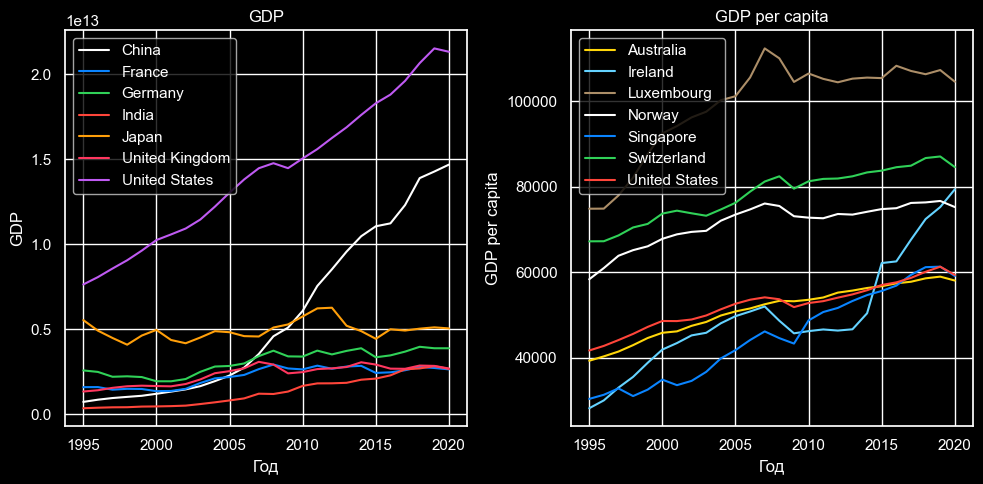

In [322]:
plt.figure("GDP", figsize=(10, 5))

attributes = ["GDP", "GDP per capita"]


for i in range(2):
    axis = plt.subplot(1, 2, i + 1)
    plt.title(attributes[i])
    for country, series in df[df["group"] == i + 1].groupby(["country"]):
        axis = series.plot(
            x="date",
            y=attributes[i],
            label=country[0],
            xlabel="Год",
            ylabel=attributes[i],
            ax=axis,
            color=next(color_gen)
        )

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/GDP 1.png", transparent=True)
plt.show()

### Показатели "наоброт" для других групп (для сравнения)

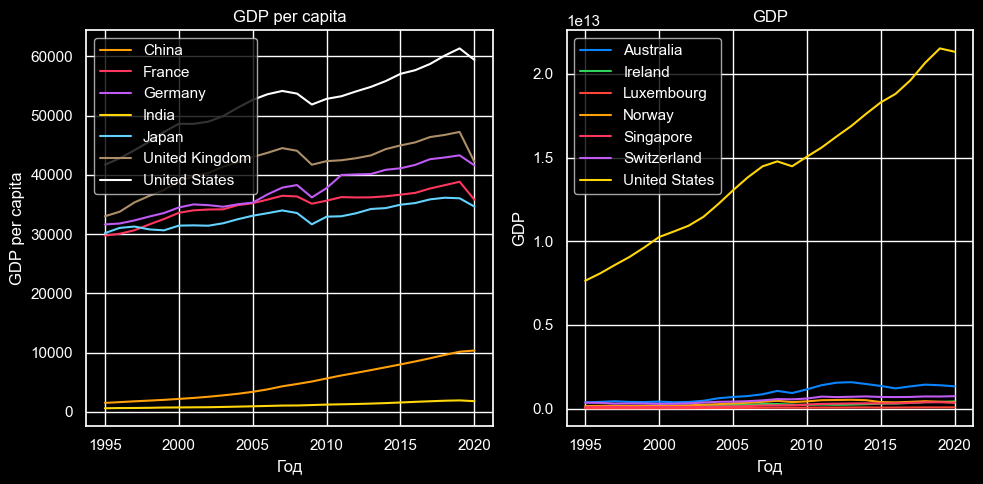

In [323]:
plt.figure("GDP", figsize=(10, 5))

attributes = ["GDP per capita", "GDP"]


for i in range(2):
    axis = plt.subplot(1, 2, i + 1)
    plt.title(attributes[i])
    for country, series in df[df["group"] == i + 1].groupby(["country"]):
        axis = series.plot(
            x="date",
            y=attributes[i],
            label=country[0],
            xlabel="Год",
            ylabel=attributes[i],
            ax=axis,
            color=next(color_gen)
        )

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/GDP 2.png", transparent=True)
plt.show()

# Экономика
### Инфляция и безработица

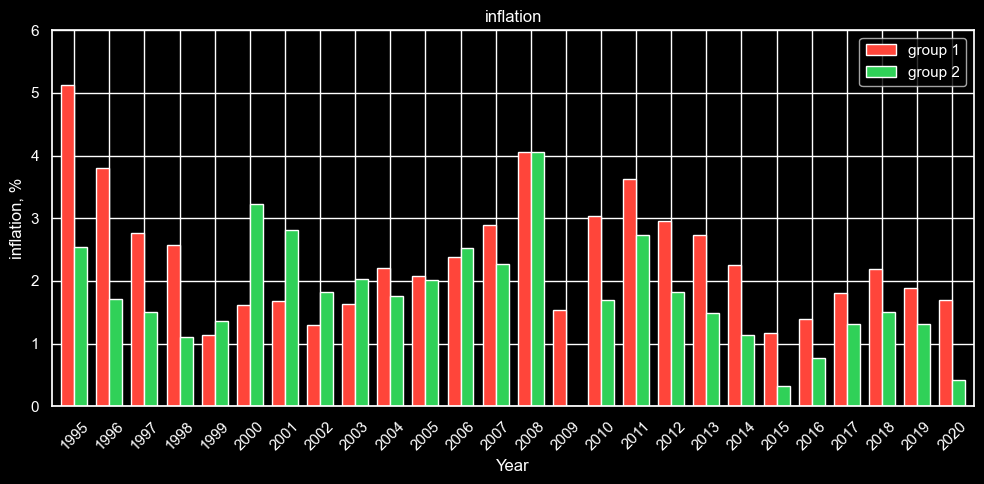

In [324]:
fig = plt.figure("Inflation", figsize=(10, 5))

attribute = "inflation"


axis = plt.subplot()
plt.title(attribute)

means = (
    df.groupby(["date", "group"])
    .aggregate({attribute: "mean"})
    .unstack(level=1)
)
axis = means.plot(
    kind="bar",
    ylabel=attribute + ", %",
    rot=45,
    xlabel="Year",
    ax=axis,
    color=[my_colors['red'], my_colors['green']],
    width=0.74,
)
axis.set_ylim(0, 6)
plt.legend(labels=["group 1", "group 2"])

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/inflation.png", transparent=True)
plt.show()

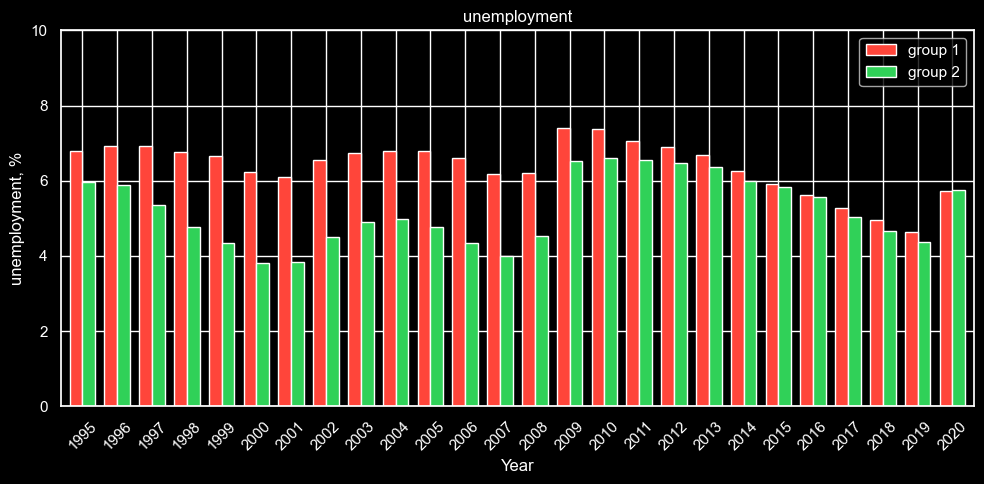

In [325]:
fig = plt.figure("Unemployment", figsize=(10, 5))

attribute = "unemployment"


axis = plt.subplot()
plt.title(attribute)

means = (
    df.groupby(["date", "group"])
    .aggregate({attribute: "mean"})
    .unstack(level=1)
)
axis = means.plot(
    kind="bar",
    ylabel=attribute + ", %",
    rot=45,
    xlabel="Year",
    ax=axis,
    color=[my_colors['red'], my_colors['green']],
    width=0.74,
)
axis.set_ylim(0, 10)
plt.legend(labels=["group 1", "group 2"])

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/unemployment.png", transparent=True)
plt.show()

### Выводы об инфляции и безработице


## Состав экспорта

In [326]:
for i in ["goods imports", 'services imports']:
    df[i] = df[i] / df['total imports'] * 100
for i in ["goods exports", 'services exports']:
    df[i] = df[i] / df['total exports'] * 100

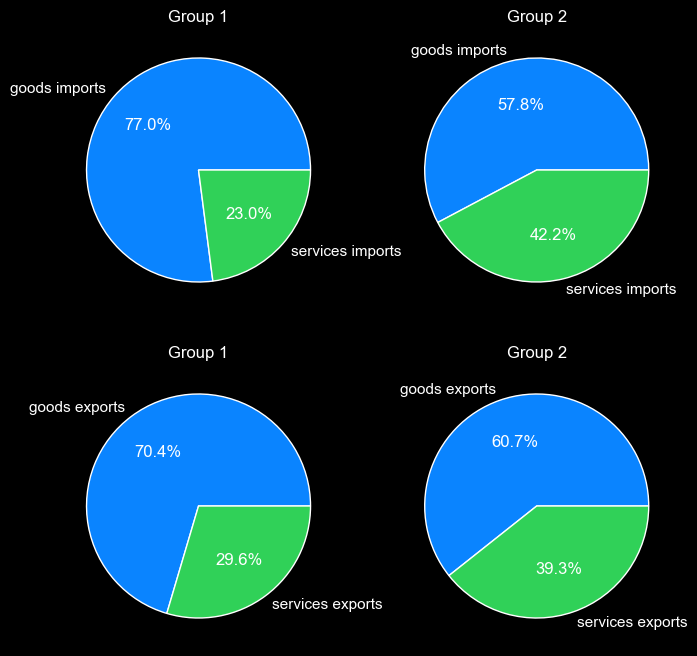

In [327]:
attributes = [
    ["goods imports", "services imports"], # imports
    ["goods exports", "services exports"], # exports
]

n_last_years = 1

figure = plt.figure("Imports and exports", figsize=(8, 8))

for i in range(2):
    pie_df = (
        df[df["date"] > end_year - n_last_years]
        .groupby(["group"])
        .aggregate({attr: "mean" for attr in attributes[i]})
        .reset_index()
        .transpose()
    )

    for j in range(2):
        axis = plt.subplot(2, 2, i * 2 + j + 1)
        axis.set_title(f'Group {j + 1}')
        axis.pie(
            x=pie_df[j].drop(index="group"),
            autopct="%1.1f%%",
            labels=pie_df.drop(index="group").index,
            colors=[my_colors['blue'], my_colors['green']]
    )

if save_plots_to_file:
    plt.savefig("pics/imports-and-exports.png", transparent=True)
plt.show()

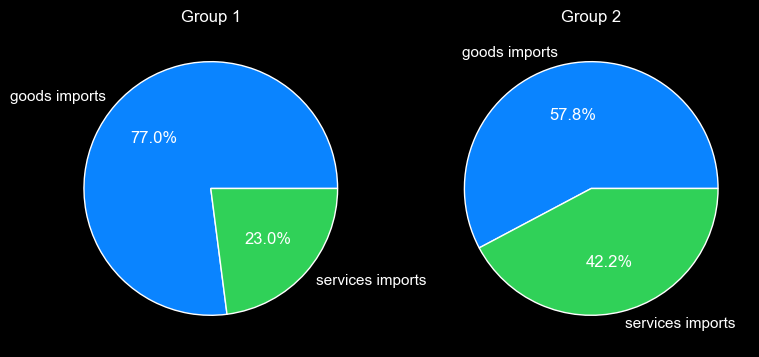

In [328]:
attributes = ["goods imports", "services imports"]

figure = plt.figure("Imports", figsize=(9, 5))

pie_df = (
    df[df["date"] == end_year]
    .groupby(["group"])
    .aggregate({attr: "mean" for attr in attributes})
    .reset_index()
    .transpose()
)

for j in range(2):
    axis = plt.subplot(1, 2, j + 1)
    axis.set_title(f'Group {j + 1}')
    axis.pie(
        x=pie_df[j].drop(index="group"),
        autopct="%1.1f%%",
        labels=pie_df.drop(index="group").index,
        colors=[my_colors['blue'], my_colors['green']]
)

if save_plots_to_file:
    plt.savefig("pics/imports.png", transparent=True)
plt.show()

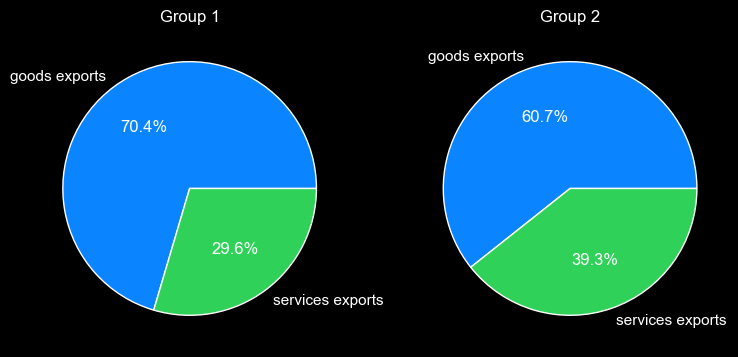

In [329]:
attributes = ["goods exports", "services exports"]

figure = plt.figure("Exports", figsize=(9, 5))

pie_df = (
    df[df["date"] == end_year]
    .groupby(["group"])
    .aggregate({attr: "mean" for attr in attributes})
    .reset_index()
    .transpose()
)

for j in range(2):
    axis = plt.subplot(1, 2, j + 1)
    axis.set_title(f'Group {j + 1}')
    axis.pie(
        x=pie_df[j].drop(index="group"),
        autopct="%1.1f%%",
        labels=pie_df.drop(index="group").index,
        colors=[my_colors['blue'], my_colors['green']]
)

if save_plots_to_file:
    plt.savefig("pics/exports.png", transparent=True)
plt.show()

### Портреты стран разных групп

# Сравнение показателей, определяющих уровень жизни

## Численность населения

In [330]:
# data for presentation
df[df["date"] == end_year][["country", "group", "population"]].sort_values(
    ["group", "population"], ascending=[True, False]
)

,country,group,population
4851,China,1,1.411100e+09
7388,India,1,1.396387e+09
13471,United States,1,3.315269e+08
7918,Japan,1,1.262610e+08
6528,Germany,1,8.316087e+07
6247,France,1,6.757111e+07
13407,United Kingdom,1,6.708123e+07
13471,United States,2,3.315269e+08
3228,Australia,2,2.564925e+07
12513,Switzerland,2,8.638167e+06


## Средний годовой доход

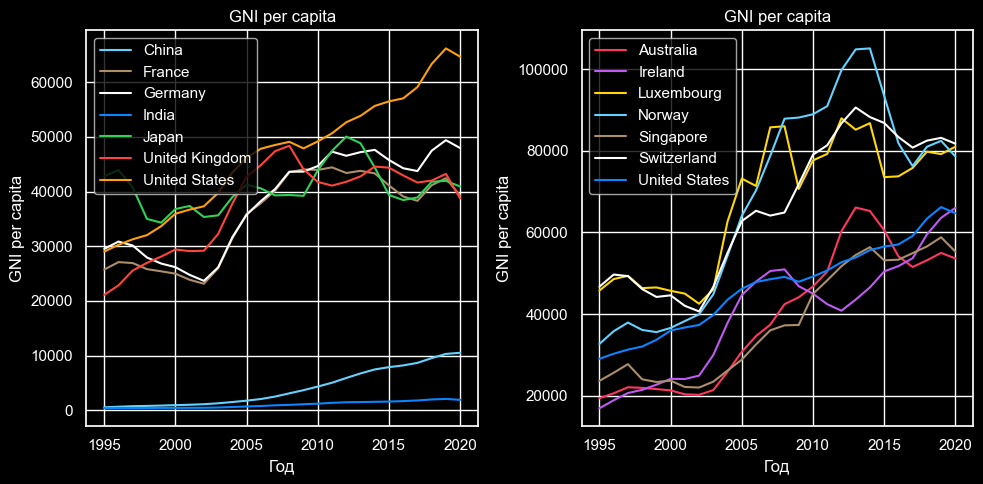

In [331]:
plt.figure("GNI", figsize=(10, 5))

attribute = "GNI per capita"

for i in range(2):
    axis = plt.subplot(1, 2, i + 1)
    plt.title(attribute)
    for country, series in df[df["group"] == i + 1].groupby(["country"]):
        axis = series.plot(
            x="date",
            y=attribute,
            label=country[0],
            xlabel="Год",
            ylabel=attribute,
            ax=axis,
            color=next(color_gen),
        )

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/GNI.png", transparent=True)
plt.show()

На этих графиках заметна динамика во времени, теперь сравнение между собой

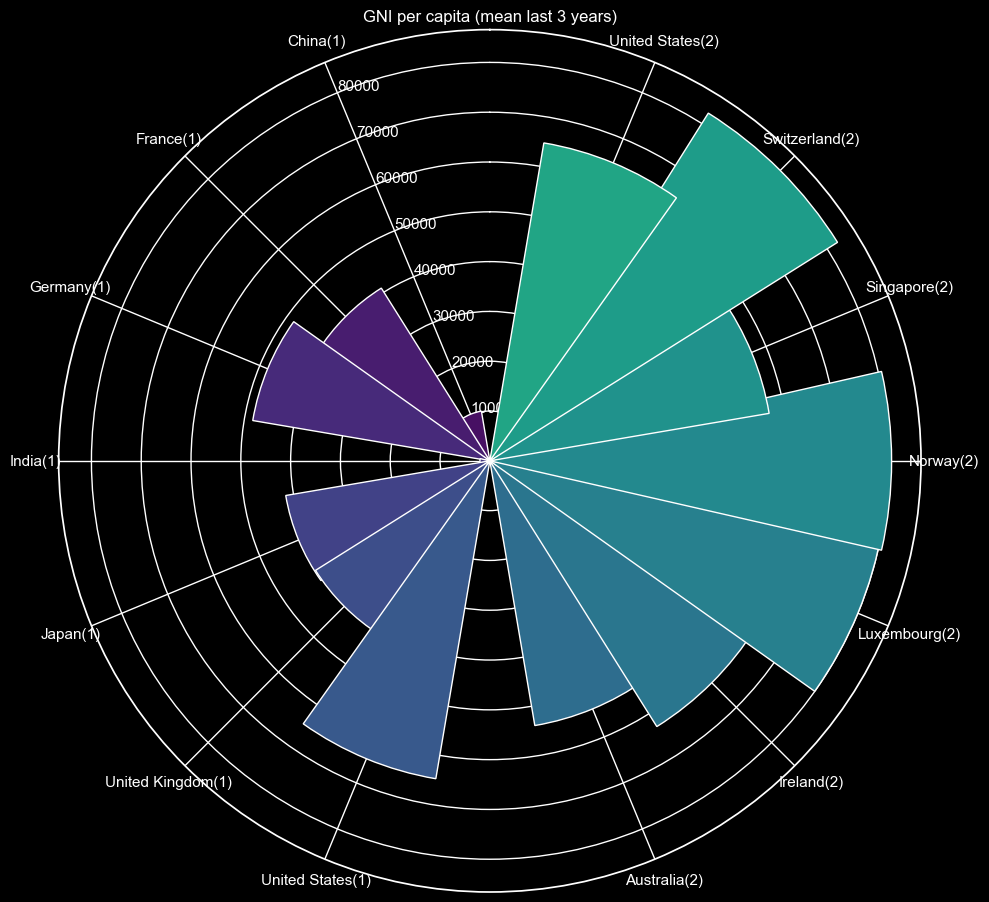

In [332]:
plt.figure("GNI", figsize=(10, 10))

attribute = "GNI per capita"

axis = plt.subplot(projection='polar')
#axis = plt.subplot()


n_last_years = 3

means = (
    df[df["date"] > end_year - n_last_years]
    .groupby(["country", 'group'])
    .aggregate({attribute: "mean"})
    .reset_index()
    .sort_values(['group', 'country'])
)


n = len(means)
step = 2 * np.pi / (n + 2)
angles = np.arange(step, np.pi, step)
angles = np.concatenate([angles, angles + np.pi])
means['angles'] = angles
means['labels'] = means['country'] + '(' + means['group'].map(str) + ')'

axis.bar(
    x=means['angles'],
    width=2*np.pi/n,
    height=means['GNI per capita'],
    tick_label=means['labels'],
    color=plt.cm.viridis(angles / 10.),
)
axis.set_theta_offset(np.pi/2)
plt.title(f'GNI per capita (mean last {n_last_years} years)')

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/GNI-round.png", transparent=True)
plt.show()

## Рождаемость и смертность

In [333]:
# отрицание значений, чтобы правильно отобразить на графике
df["death rate"] = -df["death rate"]

Mean birth rate in 1 group: 10.441714285714285
Mean birth rate in 2 group: 10.285714285714286
Mean death rate in 1 group: 9.67
Mean death rate in 2 group: 7.409999999999999


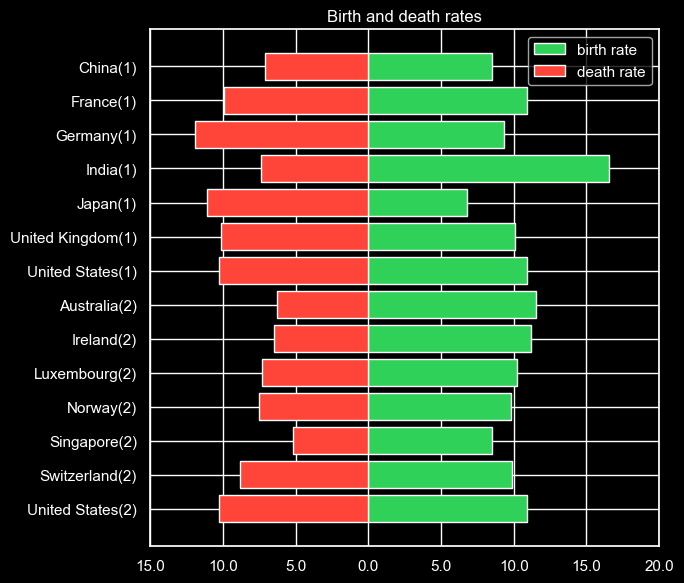

In [334]:
### Рождаемость и смертность
attributes = ["birth rate", "death rate"]

figure = plt.figure("Life expectancy", figsize=(7, 6))

axis = plt.subplot()

for i in range(2):
    data = (
        df[df["date"] == end_year][["country", "group", attributes[i]]]
        .sort_values(["group", "country"], ascending=False)
        .reset_index(drop=True)
    )
    data["labels"] = data["country"] + "(" + data["group"].map(str) + ")"
    for j in range(2):
        print(
            f"Mean {attributes[i]} in {j + 1} group:",
            abs(data[data["group"] == j + 1][attributes[i]].mean()),
        )
    axis.barh(
        y=data["labels"],
        width=data[attributes[i]],
        color=[my_colors['green'], my_colors['red']][i]
    )

plt.legend(labels=attributes)
plt.xticks(ticks=plt.xticks()[0], labels=map(lambda x: str(abs(x)), plt.xticks()[0]))
plt.title("Birth and death rates")
plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/birth-and-death-rates.png", transparent=True)
plt.show()

## Ожидаемая продолжительность жизни

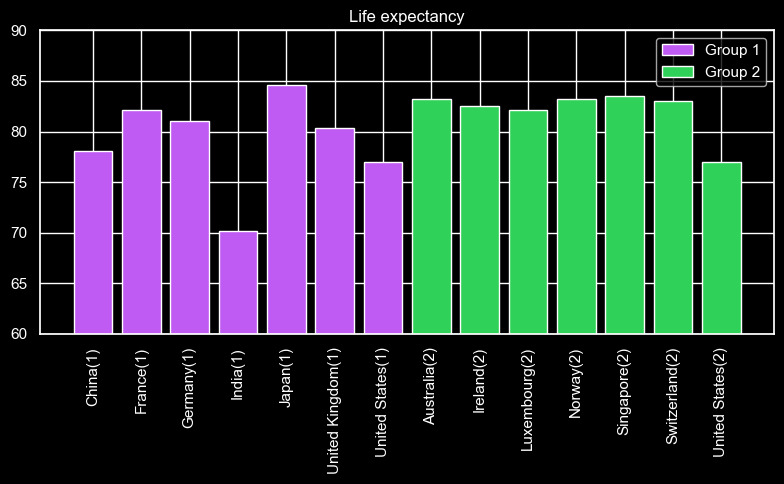

In [335]:
figure = plt.figure("Life expectancy", figsize=(8, 5))

axis = plt.subplot()

data = df[df["date"] == end_year][["country", "group", "life expectancy"]].sort_values(
    ["group", "country"]
).reset_index(drop=True)
data["labels"] = data["country"] + "(" + data["group"].map(str) + ")"
n = len(data)

axis.bar(
    x=data['labels'],
    height=data[data['group'] == 1]['life expectancy'].to_list() + [0] * (n // 2),
    color=my_colors['purple']
)
axis.bar(
    x=data['labels'],
    height=[0] * (n // 2) + data[data['group'] == 2]['life expectancy'].to_list(),
    color=my_colors['green'],
)
plt.xticks(rotation=90)
plt.ylim(60, 90)
plt.legend(labels=['Group 1', 'Group 2'])
plt.title('Life expectancy')
plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/life-expectancy.png", transparent=True)
plt.show()

## Медицина и образование

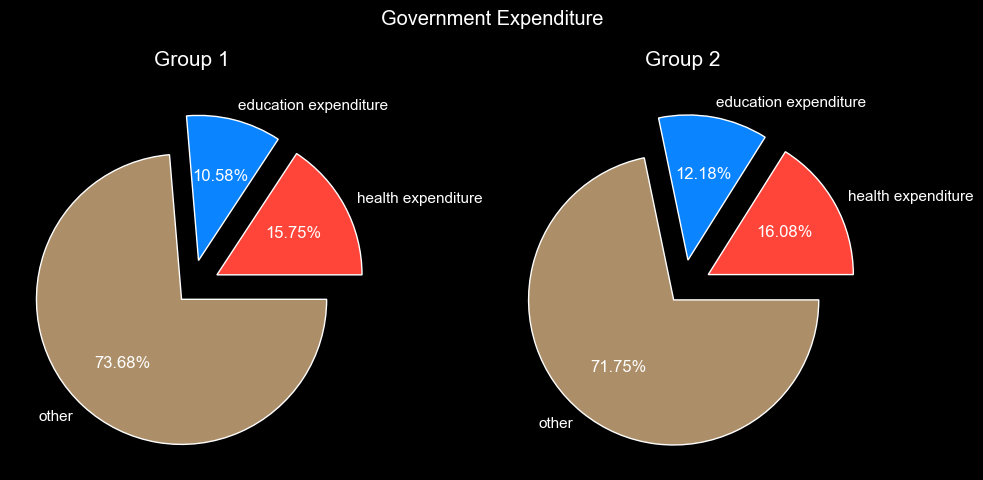

In [336]:
# извлекаем нужные данные и представляем в удобном виде
expenditure_data = (
    df[df["date"] == end_year][
        ["country", "health expenditure", "education expenditure", "group"]
    ]
    .sort_values(["group", "country"])
    .groupby(["group"])
    .aggregate({"health expenditure": "mean", "education expenditure": "mean"})
    .reset_index()
    .set_index("group")
    .transpose()  # можно обращаться по номеру группы как по индексу (1 или 2)
)

fig = plt.figure("Expenditure", (10, 5))

for i in range(2):
    values = expenditure_data[i + 1].to_list()
    labels = expenditure_data.index.to_list()

    values.append(100 - sum(values))
    labels.append("other")

    axis = plt.subplot(1, 2, i + 1)

    axis.pie(
        x=values,
        labels=labels,
        explode=[0.2, 0.2, 0.1], autopct="%.2f%%",
        colors=[
            my_colors['red'],
            my_colors['blue'],
            my_colors['brown']
        ]
    )
    axis.set_title(f"Group {i + 1}", fontdict={'fontsize': 15}, pad=30)


fig.suptitle("Government Expenditure")
plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/expenditure.png", transparent=True)
plt.show()

#### Доля людей с высшим образованием

       educational attainment
group                        
1                   24.224111
2                   36.166173


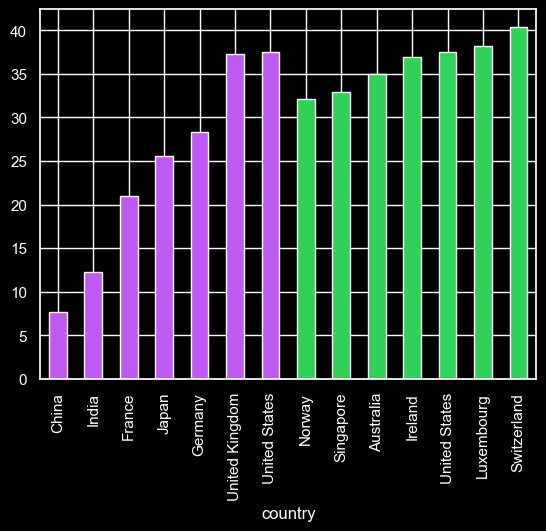

In [337]:
edu_data = df[df["date"] == end_year][
    ["country", "educational attainment", "group"]
].sort_values(["group", "educational attainment"])
edu_data.plot(
    kind="bar",
    x="country",
    y="educational attainment",
    color=[my_colors["purple"]] * N + [my_colors["green"]] * N,
    legend=False
)
print(edu_data.groupby(["group"]).agg({"educational attainment": "mean"}))

## Далее однотипные диаграммы со сравнением разных показателей
##### Количество самоубийств

       suicide mortality rate
group                        
1                   12.314286
2                   12.428571


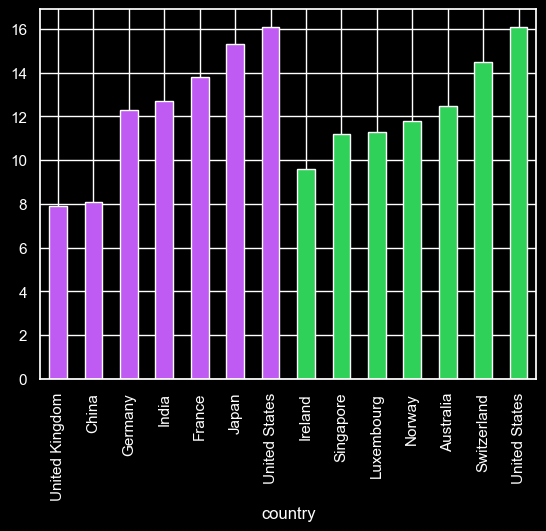

In [338]:
ind = "suicide mortality rate"
data = df[df["date"] == 2019][
    ["country", ind, "group"]
].sort_values(["group", ind])
data.plot(
    kind="bar",
    x="country",
    y=ind,
    color=[my_colors["purple"]] * N + [my_colors["green"]] * N,
    legend=False,
)
print(data.groupby(["group"]).aggregate({"suicide mortality rate": "mean"}))

##### Доступ к системе водоснабжения с **питьевой** водой

       basic water services
group                      
1                 98.136553
2                 99.381462


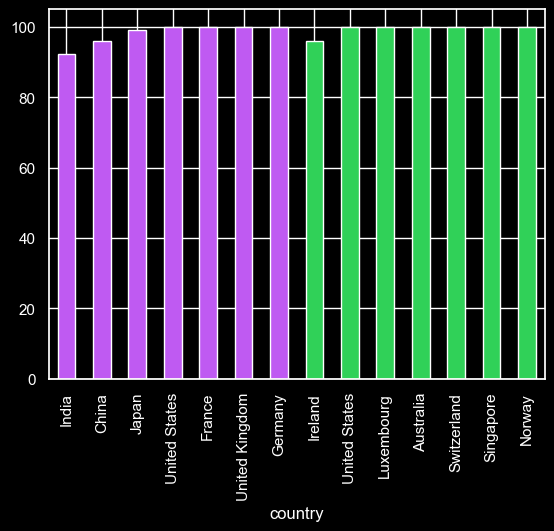

In [339]:
ind = "basic water services"
data = df[df["date"] == 2020][
    ["country", ind, "group"]
].sort_values(["group", ind])
data.plot(
    kind="bar",
    x="country",
    y=ind,
    color=[my_colors["purple"]] * N + [my_colors["green"]] * N,
    legend=False,
)
print(data.groupby(["group"]).aggregate({ind: "mean"}))

##### Потребление алкоголя (л/год на человека)

       alcohol consumption
group                     
1                 8.748571
2                 8.851429


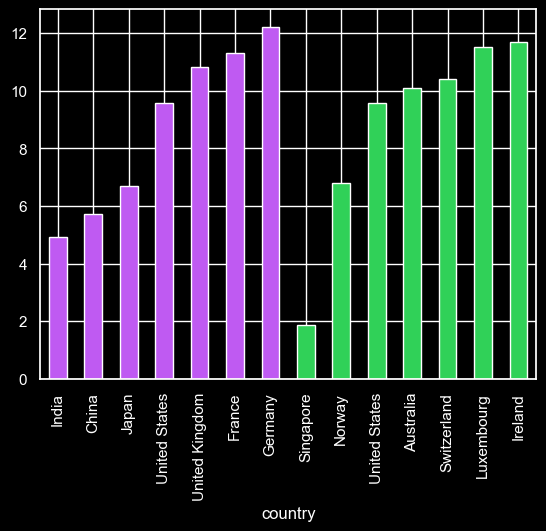

In [340]:
ind = "alcohol consumption"
data = df[df["date"] == 2019][
    ["country", ind, "group"]
].sort_values(["group", ind])
data.plot(
    kind="bar",
    x="country",
    y=ind,
    color=[my_colors["purple"]] * N + [my_colors["green"]] * N,
    legend=False,
)
print(data.groupby(["group"]).aggregate({ind: "mean"}))

##### Доля людей, пошедших в школу


       primary school enrollment
group                           
1                     101.443231
2                     100.196191


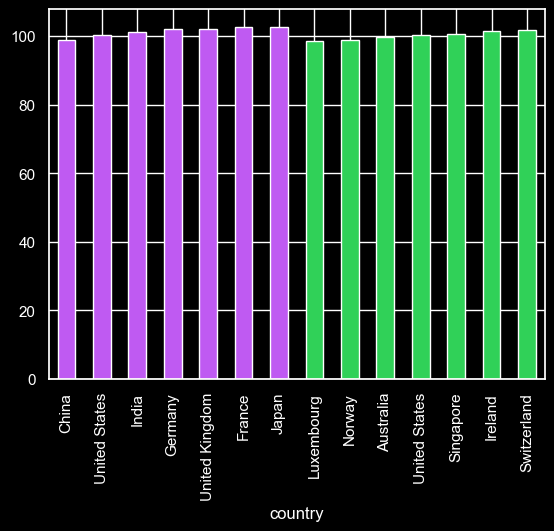

In [341]:
ind = "primary school enrollment"
data = df[df["date"] == 2020][
    ["country", ind, "group"]
].sort_values(["group", ind])
data.plot(
    kind="bar",
    x="country",
    y=ind,
    color=[my_colors["purple"]] * N + [my_colors["green"]] * N,
    legend=False,
)
print(data.groupby(["group"]).aggregate({ind: "mean"}))

#### Доля людей, продолживших получение образования после школы

       secondary school enrollment
group                             
1                       100.251299
2                       115.379561


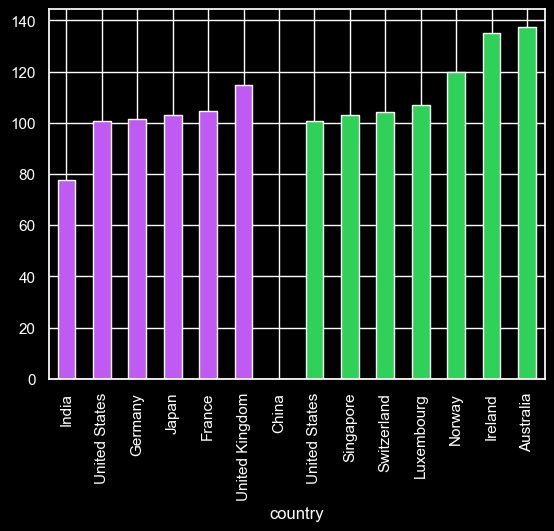

In [342]:
ind = "secondary school enrollment"
data = df[df["date"] == 2020][
    ["country", ind, "group"]
].sort_values(["group", ind])
data.plot(
    kind="bar",
    x="country",
    y=ind,
    color=[my_colors["purple"]] * N + [my_colors["green"]] * N,
    legend=False,
)
print(data.groupby(["group"]).aggregate({ind: "mean"}))

#### Доля людей, поступивших в высшие учебные заведения

       tertiary school enrollment
group                            
1                       64.650094
2                       77.245647


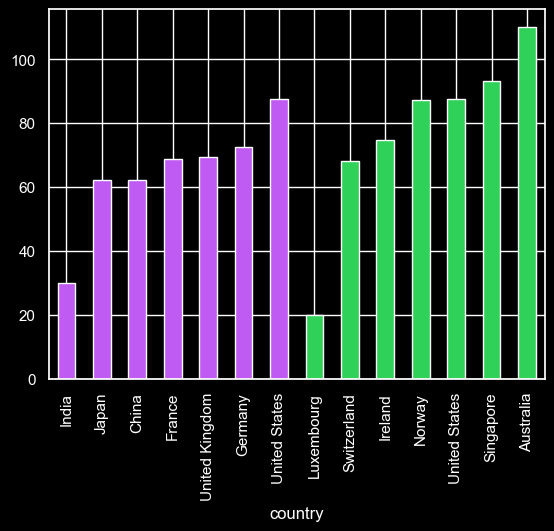

In [343]:
ind = "tertiary school enrollment"
data = df[df["date"] == 2020][
    ["country", ind, "group"]
].sort_values(["group", ind])
data.plot(
    kind="bar",
    x="country",
    y=ind,
    color=[my_colors["purple"]] * N + [my_colors["green"]] * N,
    legend=False,
)
print(data.groupby(["group"]).aggregate({ind: "mean"}))

       air pollution
group               
1          73.432020
2          35.518635


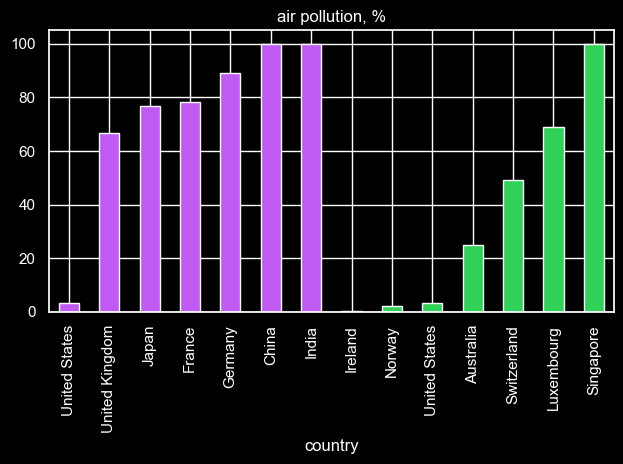

In [349]:
ind = "air pollution"
data = df[df["date"] == 2017][
    ["country", ind, "group"]
].sort_values(["group", ind])
data.plot(
    kind="bar",
    x="country",
    y=ind,
    color=[my_colors["purple"]] * N + [my_colors["green"]] * N,
    legend=False,
    title=ind + ", %"
)
plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/air-pollution.png", transparent=True)
print(data.groupby(["group"]).aggregate({ind: "mean"}))

### Кластеризация для разбиения стран на группы
**добавить теорию про кластеризацию**

In [517]:
from sklearn.cluster import KMeans

n_clusters = 5

data = cleared_df[cleared_df['date'] == 2017].drop(columns=['date']).fillna(0)
data.set_index('country', inplace=True)
x = data.to_numpy()
kmeans = KMeans(n_clusters=n_clusters).fit(x)

clustered = data.copy()
clustered['cluster'] = kmeans.predict(x)

for i in range(n_clusters):
    print(f"Cluster {i}:", clustered[clustered['cluster'] == i].index.to_list())

Cluster 0: ['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Cayman Islands', 'Central African Republic', 'Chad', 'Channel Islands', 'Chile', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji', 'Finland', 'French Polynesia', 'Gabon', 'Gambia, The', 'Georgia', 'Ghana', 'Greece', 'Greenland', 'Grenada', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyan

c:\Users\redun\anaconda3\envs\mlmethods\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### PCA
**добавить теорию про PCA**

Уменьшим размерность пространства признаков, чтобы выявить наиболее значимые из них.

In [529]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5).fit(data)
pca_res = pca.transform(data)

n_pcs= pca.components_.shape[0]

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

features = pca.feature_names_in_

print("The most important indicators:", ', '.join([features[i] for i in most_important]))

The most important indicators: GDP, total exports, goods exports, goods imports, services imports


# Выводы